In [1]:
import torch
import numpy as np
import pickle
import copy
import matplotlib.pyplot as plt

## CONFIG

In [2]:

## The node that you want to INSPECT:
INSPECTED_NODE = 0

###########
NUM_SAMPLES = 10
dm = 13
NUM_FEATURES = int(NUM_SAMPLES * dm)
STD = 0.01
NUM_CLUSTERS = 2
NUM_CLIENTS = 100
NUM_ROUNDS = 2000
LEARNING_RATE = 0.01
NUM_RUNS = 40



## ALGORITHM

In [3]:
def create_true_underlying_w(num_features):
    one_hotted_GT = torch.from_numpy(np.eye(NUM_CLUSTERS)[np.random.choice(NUM_CLUSTERS,
                                                                           NUM_CLIENTS)].T)  # creates a matrix and indicates which client belongs to which cluster it has k rows and n coloumns
    core_GT_weights = torch.from_numpy(np.random.uniform(low=-10, high=10, size=(num_features, NUM_CLUSTERS)))  # (d, k)
    clients_GT_weights = core_GT_weights @ one_hotted_GT  # (d, n) = (d, k) @ (k, n)

    return one_hotted_GT, clients_GT_weights


class Client:
    def __init__(self, num_samples, num_features, weights, true_w, STD):
        self.weights = weights

        self.X, self.y = generate_data(num_samples, num_features,
                                       true_w, STD)
        self.GT_w = true_w

    def get_local_loss(self, weights):
        prediction = self.X @ weights
        loss_ = ((prediction - self.y) ** 2).mean()
        return loss_

    def train_locally(self, L, lr):
        weights = self.weights.clone()
        for l in range(0, L):
            weights.requires_grad_()
            weights.grad = None
            prediction = self.X @ weights
            loss_ = ((prediction - self.y) ** 2).mean()
            loss_.backward()
            grad = weights.grad.clone()
            with torch.no_grad():
                weights = weights - lr * grad
        self.weights = weights.detach()
        return weights.detach()

    def eval(self, weights):
        with torch.no_grad():
            return ((self.GT_w - weights).norm(p=2)).item()


def generate_data(num_samples, num_features, true_w, STD):
    """Generate synthetic data for a user."""
    X = torch.randn(num_samples, num_features, dtype=torch.float64)
    y = X @ true_w + STD * torch.randn(num_samples, 1)
    return X, y


def get_clients_list(num_features, clients_GT_weights):
    w_init_mat = torch.randn(num_features, NUM_CLIENTS, requires_grad=False, dtype=torch.float64)
    clients_list = []
    for client_iter in range(NUM_CLIENTS):
        GT_w = clients_GT_weights[:, client_iter].reshape(-1, 1)
        w = w_init_mat[:, client_iter].reshape(-1, 1).clone()
        clients_list.append(Client(NUM_SAMPLES, num_features, w, GT_w, STD))
    return clients_list


def find_w_candidate(current_weight, X, y, lr):
    current_weight.requires_grad_()
    current_weight.grad = None
    prediction = X @ current_weight
    loss_ = ((prediction - y) ** 2).mean()
    loss_.backward()
    with torch.no_grad():
        w_candidate = current_weight - lr * current_weight.grad
    return w_candidate


def get_w_candidates(clients_list, curr_client_id, num_features, client_ids, lr):
    curr_weight = clients_list[curr_client_id].weights.clone()
    candidates = torch.zeros((num_features, SUBSET_SIZE), dtype=torch.float64)
    for iter_client in range(SUBSET_SIZE):
        id_ = client_ids[iter_client]
        client = clients_list[id_]
        w_iter = find_w_candidate(curr_weight.clone(), client.X, client.y, lr)
        candidates[:, iter_client] = w_iter.clone().squeeze()
    return candidates


def get_w_with_best_reward(num_features, candidates, client_ids, client):
    current_loss = client.get_local_loss(client.weights)
    rewards = torch.empty((SUBSET_SIZE), dtype=torch.float64)
    for iter_client in range(SUBSET_SIZE):
        rewards[iter_client] = current_loss - client.get_local_loss(candidates[:, iter_client].reshape(num_features, 1))
    idx_max_reward = torch.argmax(rewards)
    return candidates[:, idx_max_reward], client_ids[idx_max_reward].item(), rewards[idx_max_reward].item()


def get_random_indices_without_i():
    indices = np.arange(0, NUM_CLIENTS)
    total_client_ids = np.empty((SUBSET_SIZE, NUM_CLIENTS), dtype=int)

    for iter_client in range(NUM_CLIENTS):
        available_indices = np.delete(indices, iter_client)
        random_indices = np.random.choice(available_indices, size=SUBSET_SIZE, replace=False)
        total_client_ids[:, iter_client] = random_indices
    return total_client_ids


def algorithm(clients_list, num_features, num_rounds, lr):
    
    mat_history_rewards = np.empty((num_rounds, NUM_CLIENTS))
    mat_history_idx_best_candid = np.empty((num_rounds, NUM_CLIENTS), dtype=int)
    hist_loss = np.empty((num_rounds, NUM_CLIENTS))
    hist_loss_valid = np.empty((num_rounds, NUM_CLIENTS))
    norm_grad = np.empty((num_rounds, NUM_CLIENTS))
    
    for round_ in range(num_rounds):
        total_subsets = get_random_indices_without_i()
        w_mat = torch.empty((num_features, NUM_CLIENTS), dtype=torch.float64)
        
        for iter_client in range(NUM_CLIENTS):
            if iter_client != INSPECTED_NODE:
                continue
            curr_client_candidates = get_w_candidates(clients_list, iter_client, num_features,
                                                      total_subsets[:, iter_client], lr)

            w_mat[:, iter_client], mat_history_idx_best_candid[round_, iter_client], mat_history_rewards[round_,
            iter_client] = get_w_with_best_reward(num_features,
                                                  curr_client_candidates, total_subsets[:, iter_client],
                                                  clients_list[iter_client])
            
            grad = w_mat[:, iter_client].reshape(-1, 1) - clients_list[iter_client].weights
            norm_grad[round_, iter_client] = np.linalg.norm(grad)

        loss = []
        loss_valid = []
        
        for iter_client in range(NUM_CLIENTS):
            if iter_client != INSPECTED_NODE:
                continue
            loss.append(clients_list[iter_client].eval(clients_list[iter_client].weights.detach()))
            loss_valid.append(clients_list[iter_client].get_local_loss(clients_list[iter_client].weights.detach()).item())
            clients_list[iter_client].weights = w_mat[:, iter_client].clone().reshape(-1, 1)
        hist_loss[round_, :] = loss
        hist_loss_valid[round_, :] = loss_valid
    return mat_history_rewards, mat_history_idx_best_candid, hist_loss, hist_loss_valid, norm_grad


In [4]:
def change_clients_w_init(clients_list, w_init_mat):
    
    for client_iter in range(NUM_CLIENTS):
        clients_list[client_iter].weights = w_init_mat[:, client_iter].reshape(-1, 1)
    return clients_list

## PUTTING THING TOGETHER

In [5]:
ONE_HOTTED_GT, CLIENT_GT_WEIGHT = create_true_underlying_w(NUM_FEATURES)
subset_sizes = [4, 8,16, 32, 64, 99]
clients_ls = get_clients_list(NUM_FEATURES, CLIENT_GT_WEIGHT)
w_init_mat_ = torch.randn(NUM_RUNS, NUM_FEATURES, NUM_CLIENTS, requires_grad=False, dtype=torch.float64)

num_subset_sizes = len(subset_sizes)

mean_hist_MSE_w = np.empty((num_subset_sizes, NUM_ROUNDS, NUM_CLIENTS))
mean_hist_MSE_y = np.empty((num_subset_sizes, NUM_ROUNDS, NUM_CLIENTS))
mean_hist_grads = np.empty((num_subset_sizes, NUM_ROUNDS, NUM_CLIENTS))

std_hist_MSE_w = np.empty((num_subset_sizes, NUM_ROUNDS, NUM_CLIENTS))
std_hist_MSE_y = np.empty((num_subset_sizes, NUM_ROUNDS, NUM_CLIENTS))
std_hist_grads = np.empty((num_subset_sizes, NUM_ROUNDS, NUM_CLIENTS))
total_history_idx_best_candids = np.empty((num_subset_sizes,NUM_RUNS, NUM_ROUNDS, NUM_CLIENTS), dtype=int)

for iter_subsetsize in range(num_subset_sizes):
    SUBSET_SIZE = subset_sizes[iter_subsetsize]
    hist_MSE_w = np.empty((NUM_RUNS, NUM_ROUNDS, NUM_CLIENTS))
    hist_MSE_y = np.empty((NUM_RUNS, NUM_ROUNDS, NUM_CLIENTS))
    hist_grads = np.empty((NUM_RUNS, NUM_ROUNDS, NUM_CLIENTS))
    history_idx_best_candids = np.empty((NUM_RUNS, NUM_ROUNDS, NUM_CLIENTS), dtype=int)

    for iter_run in range(NUM_RUNS):
        clients_ls = change_clients_w_init(clients_ls, w_init_mat_[iter_run, :, :].clone())
        _, idx_best_candid, hist_loss_w, hist_loss_valid, norm_grads = algorithm(clients_ls,
                                                                                            NUM_FEATURES,
                                                                                            NUM_ROUNDS,
                                                                                            LEARNING_RATE)
        history_idx_best_candids[iter_run, :, :]  = idx_best_candid

        hist_MSE_w[iter_run, :, :] = hist_loss_w 
        hist_MSE_y[iter_run, :, :] = hist_loss_valid
        hist_grads[iter_run, :, :] = norm_grads
        
    mean_hist_MSE_w[iter_subsetsize, :, :] = hist_MSE_w.mean(axis=0)
    mean_hist_MSE_y[iter_subsetsize, :, :] = hist_MSE_y.mean(axis=0)
    mean_hist_grads[iter_subsetsize, :, :] = hist_grads.mean(axis=0)
    std_hist_MSE_w[iter_subsetsize, :, :] = hist_MSE_w.std(axis=0)
    std_hist_MSE_y[iter_subsetsize, :, :] = hist_MSE_y.std(axis=0)
    std_hist_grads[iter_subsetsize, :, :] = hist_grads.std(axis=0)
    total_history_idx_best_candids[iter_subsetsize] = history_idx_best_candids

## SAVING VARIABLES

In [6]:
variables_to_save = {
    'mean_hist_MSE_w': mean_hist_MSE_w,
    'mean_hist_MSE_y': mean_hist_MSE_y,
    'mean_hist_grads': mean_hist_grads,
    'std_hist_MSE_w': std_hist_MSE_w,
    'std_hist_MSE_y': std_hist_MSE_y,
    'std_hist_grads': std_hist_grads,
    'total_history_idx_best_candids' : total_history_idx_best_candids
}

file_path = 'saved_variables.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(variables_to_save, file)

In [7]:
averaged_mean_y_all_nodes = mean_hist_MSE_y.mean(axis=2)
averaged_mean_w_all_nodes = mean_hist_MSE_w.mean(axis=2)

In [8]:
headers = []
for i in range(num_subset_sizes):
    headers.append('Nr. Candidates: ' + str(subset_sizes[i]))

data_with_headers = np.vstack([headers, np.round(averaged_mean_w_all_nodes,2).astype(str).T])
np.savetxt('averaged_mean_w_all_different_subsets.csv', data_with_headers, delimiter=',', fmt='%s')
data_with_headers = np.vstack([headers, np.round(mean_hist_MSE_w[:, :, INSPECTED_NODE],2).astype(str).T])
np.savetxt('averaged_w_INSPECTED_different_subsets.csv', data_with_headers, delimiter=',', fmt='%s')

data_with_headers = np.vstack([headers, np.round(mean_hist_MSE_y[:, :, INSPECTED_NODE],2).astype(str).T])
np.savetxt('averaged_y_INSPECTED_different_subsets.csv', data_with_headers, delimiter=',', fmt='%s')

data_with_headers = np.vstack([headers, np.round(mean_hist_grads[:, :, INSPECTED_NODE],2).astype(str).T])
np.savetxt('averaged_grads_INSPECTED_different_subsets.csv', data_with_headers, delimiter=',', fmt='%s')


## VISUALIZATION

### Last Candidates That Are Selected For Client `INSPECTED_NODE` Are Shown Below.

In [9]:
nodes = 40

for i in range(len(subset_sizes)):
    tex = f"ID of Last {nodes} candidates of selected for node i = {INSPECTED_NODE} by using SUBSET_SIZE={subset_sizes[i]}: \n"

    print(tex)
    for run_ in range(NUM_RUNS):
        print(f"TRIAL NUMBER {run_}:")
        output_text = ""
        for j in range(0, nodes):
            output_text += f"{total_history_idx_best_candids[i, run_, - nodes + j, INSPECTED_NODE]} "
        print(output_text)
    print("\n")
    


ID of Last 40 candidates of selected for node i = 0 by using SUBSET_SIZE=4: 

TRIAL NUMBER 0:
7 14 17 40 26 41 55 41 48 12 19 61 23 25 44 92 64 44 95 26 24 36 53 12 13 77 27 23 40 51 86 29 67 64 25 30 38 44 23 33 
TRIAL NUMBER 1:
64 13 94 19 23 72 13 64 14 36 84 64 19 87 54 27 90 20 54 4 7 29 16 19 23 84 15 81 27 76 5 23 17 12 14 43 83 29 61 67 
TRIAL NUMBER 2:
72 27 34 77 35 84 12 87 4 40 99 7 33 13 27 74 77 83 47 77 7 54 13 8 81 93 54 81 46 35 40 70 46 35 14 92 12 74 8 86 
TRIAL NUMBER 3:
13 13 24 44 8 76 41 4 41 72 8 27 27 94 87 15 22 17 99 80 80 7 55 28 46 41 76 92 87 95 55 84 83 26 81 84 36 46 83 35 
TRIAL NUMBER 4:
76 29 27 83 19 46 93 55 22 82 23 95 13 71 70 35 46 19 28 76 79 92 12 68 97 71 24 26 48 27 22 17 97 17 24 22 95 14 44 86 
TRIAL NUMBER 5:
14 21 7 84 33 44 36 76 87 29 41 76 81 29 46 83 61 44 29 40 13 76 14 86 86 27 64 12 7 29 23 92 83 25 23 28 86 26 71 41 
TRIAL NUMBER 6:
14 36 87 8 7 40 22 61 23 81 22 86 36 17 14 14 24 46 84 40 11 40 12 22 84 29 13 8 27 19 99 83 13 47 

#### As you can see from above if we have high subseet size, the node will only select a certain client.

### Visualizing MSE losses on:
#### 1. Validation Dataset
#### 2. Distance of Local Parameters from True Underlying Weight Vector

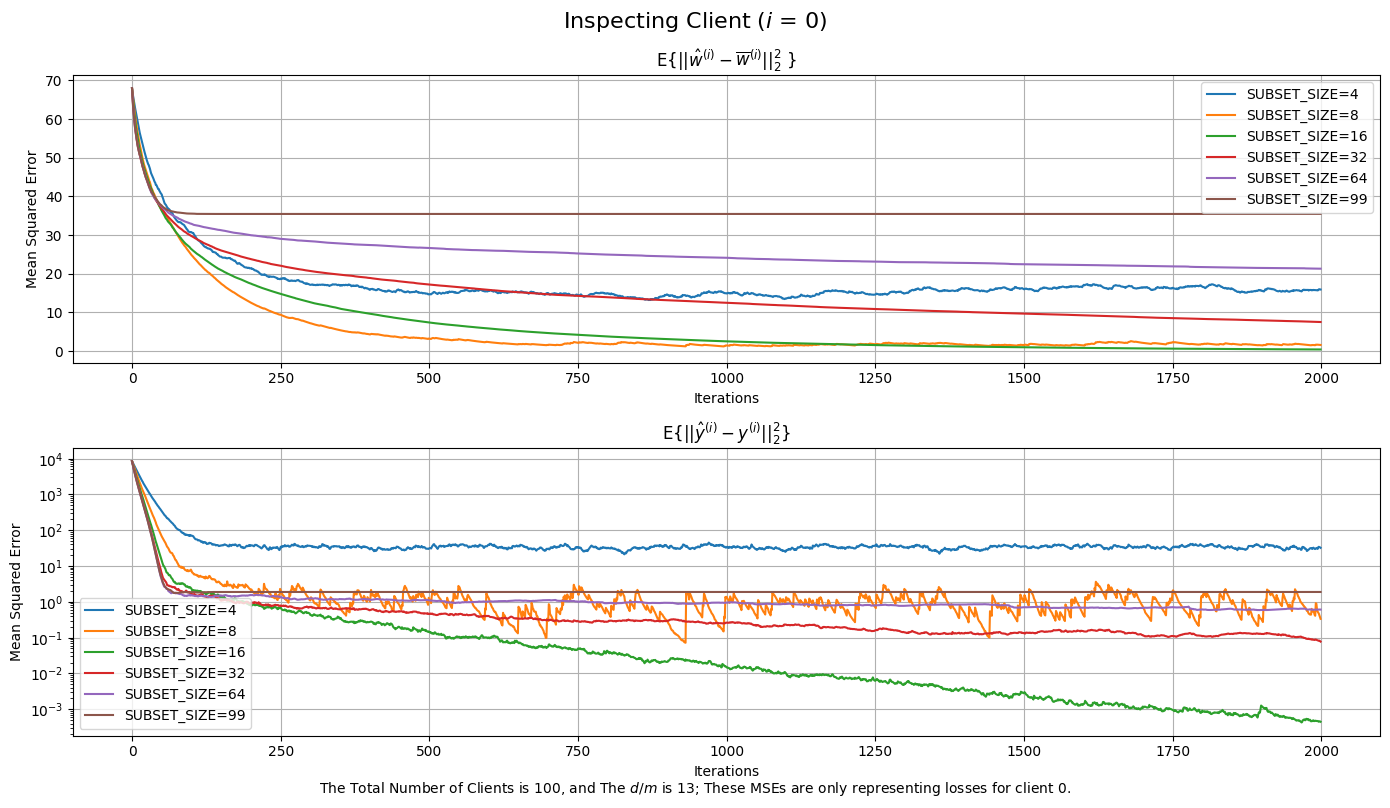

In [10]:

x = np.arange(NUM_ROUNDS)

fig, axs = plt.subplots(2, 1, figsize=(14, 8))  
plt.suptitle(f"Inspecting Client ($i$ = {INSPECTED_NODE})", fontsize=16)

for i in range(len(subset_sizes)):
    axs[0].plot(x, mean_hist_MSE_w[i, :, INSPECTED_NODE], label=f"SUBSET_SIZE={subset_sizes[i]}")

axs[0].set_title("E{${||\hat{w}^{(i)} - \overline{w}^{(i)} ||^2_2} $ }")
axs[0].legend()
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Mean Squared Error")
axs[0].grid(True)
for i in range(len(subset_sizes)):
    axs[1].plot(x, mean_hist_MSE_y[i, :, INSPECTED_NODE], label=f"SUBSET_SIZE={subset_sizes[i]}")

axs[1].set_title("E{${||\hat{y}^{(i)} - y^{(i)} ||^2_2} $}")
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Mean Squared Error")
axs[1].grid(True)
fig.text(0.5, 0.001, f"The Total Number of Clients is {NUM_CLIENTS}, and The $d/m$ is {dm}; These MSEs are only representing losses for client {INSPECTED_NODE}.",
         horizontalalignment="center");
plt.tight_layout()



### Norm of Gradient for `INSPECTED_NODE`

At each round, `INSPECTED_NODE` will select a client's gradient that have the most reward for it; I have plotted this incoming gradient's norm at each round for `INSPECTED_NODE`. 

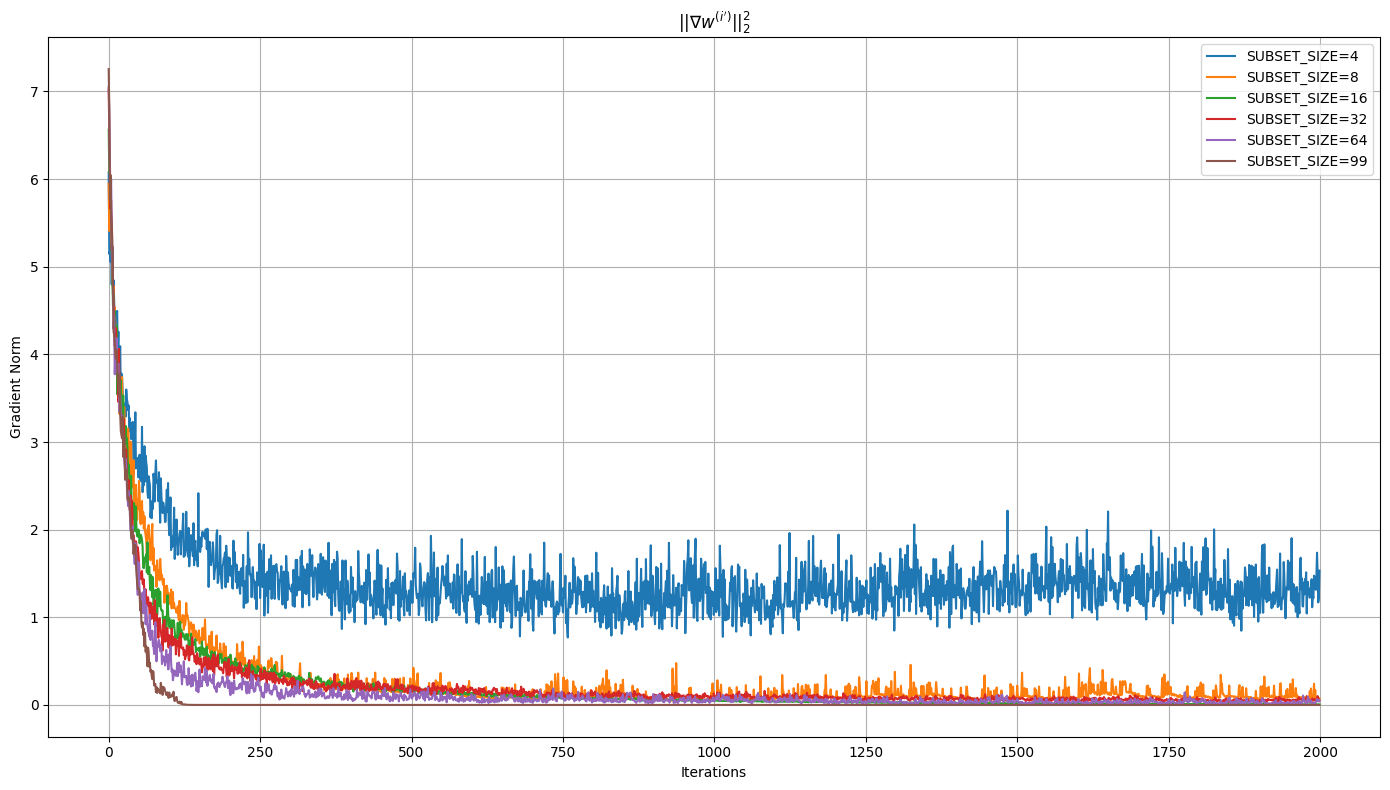

In [11]:
fig, axs = plt.subplots(figsize=(14, 8)) 

for i in range(len(subset_sizes)):
    axs.plot(x, mean_hist_grads[i,:, INSPECTED_NODE], label=f"SUBSET_SIZE={subset_sizes[i]}")

axs.set_title("${|| ∇{w}^{(i')}||^2_2} $")
axs.legend()
axs.set_xlabel("Iterations")
axs.set_ylabel("Gradient Norm")
axs.grid(True)

plt.tight_layout()
plt.show()

## Here are same plots above but looking more closely at first 100 rounds where the `INSPECTED_NODE` Stucks.

/tmp/ipykernel_20/3961343290.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1].set_ylim(0, 1000)


(0.0, 100.0)

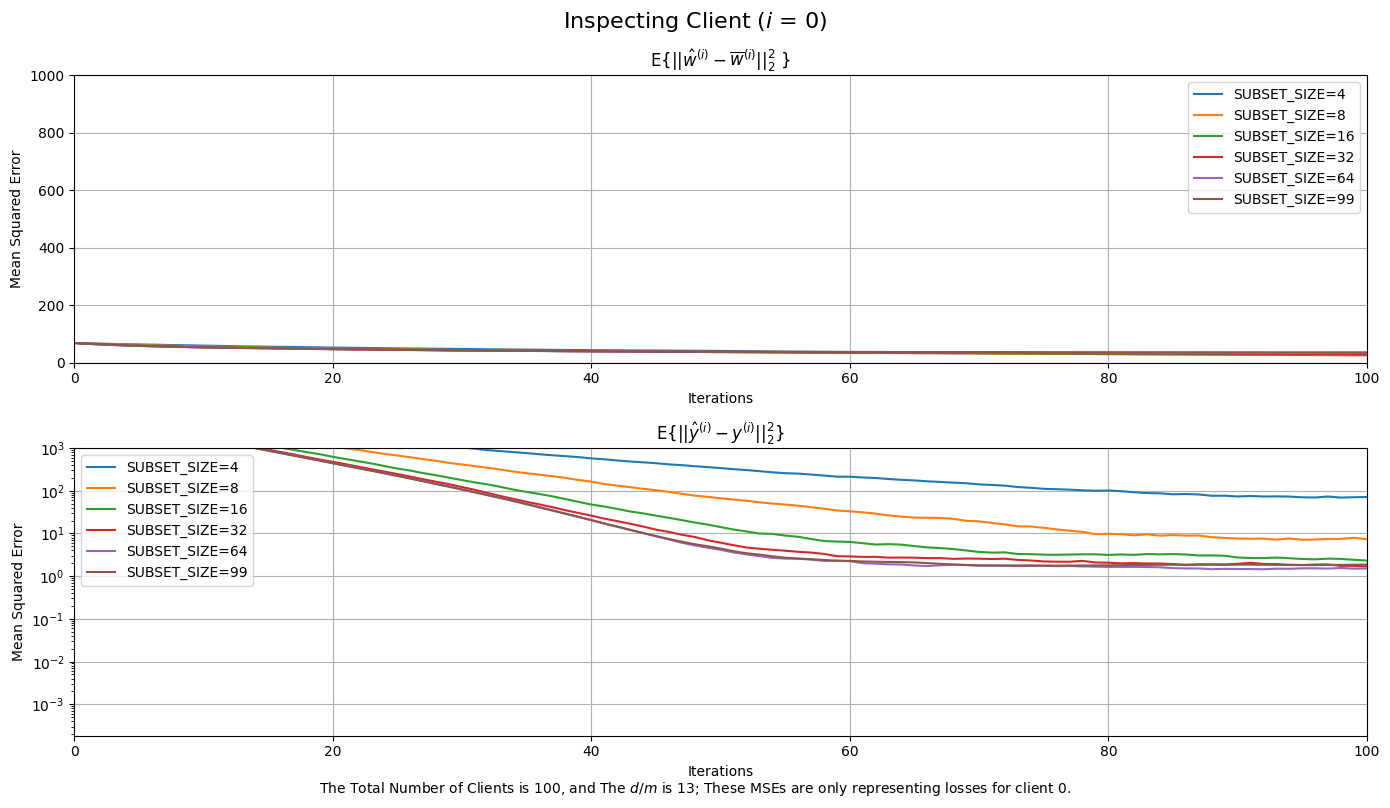

In [12]:

x = np.arange(NUM_ROUNDS)

fig, axs = plt.subplots(2, 1, figsize=(14, 8))  
plt.suptitle(f"Inspecting Client ($i$ = {INSPECTED_NODE})", fontsize=16)

for i in range(len(subset_sizes)):
    axs[0].plot(x, mean_hist_MSE_w[i, :, INSPECTED_NODE], label=f"SUBSET_SIZE={subset_sizes[i]}")

axs[0].set_title("E{${||\hat{w}^{(i)} - \overline{w}^{(i)} ||^2_2} $ }")
axs[0].legend()
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Mean Squared Error")
axs[0].grid(True)
axs[0].set_xlim(0, 100)  
axs[0].set_ylim(0, 1000)  

for i in range(len(subset_sizes)):
    axs[1].plot(x, mean_hist_MSE_y[i, :, INSPECTED_NODE], label=f"SUBSET_SIZE={subset_sizes[i]}")

axs[1].set_title("E{${||\hat{y}^{(i)} - y^{(i)} ||^2_2} $}")
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Mean Squared Error")
axs[1].grid(True)
axs[1].set_ylim(0, 1000)  
fig.text(0.5, 0.001, f"The Total Number of Clients is {NUM_CLIENTS}, and The $d/m$ is {dm}; These MSEs are only representing losses for client {INSPECTED_NODE}.",
         horizontalalignment="center");
plt.tight_layout()
axs[1].set_xlim(0, 100)  




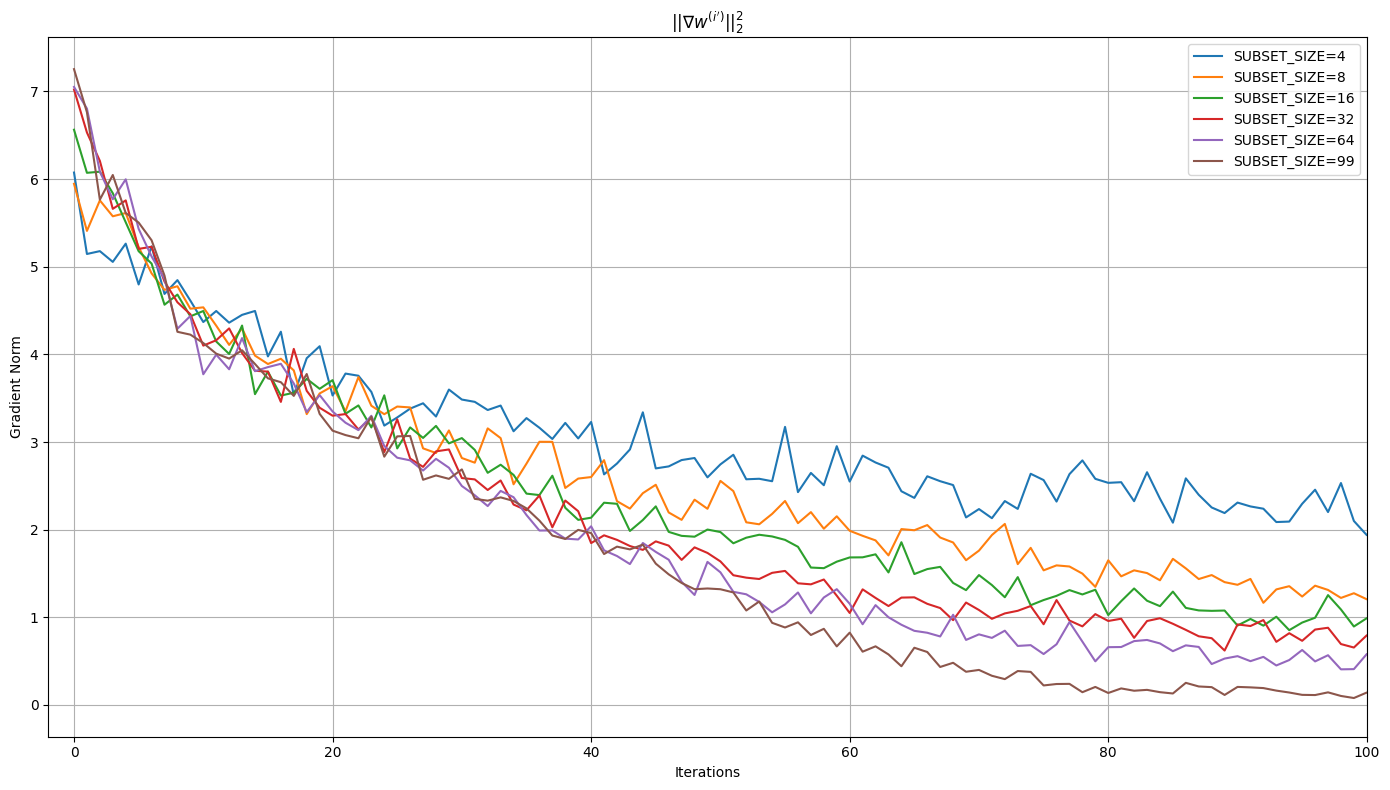

In [13]:
fig, axs = plt.subplots(figsize=(14, 8)) 

for i in range(len(subset_sizes)):
    axs.plot(x, mean_hist_grads[i,:, INSPECTED_NODE], label=f"SUBSET_SIZE={subset_sizes[i]}")

axs.set_title("${|| ∇{w}^{(i')}||^2_2} $")
axs.legend()
axs.set_xlabel("Iterations")
axs.set_ylabel("Gradient Norm")
axs.grid(True)
axs.set_xlim(-2, 100)  

plt.tight_layout()
plt.show()

In [14]:

for i in range(len(subset_sizes)):
    tex = f"ID of Last {nodes} candidates of selected for node i = {INSPECTED_NODE} by using SUBSET_SIZE={subset_sizes[i]}: \n"

    print(tex)
    for run_ in range(NUM_RUNS):
        print(f"TRIAL NUMBER {run_}:")
        output_text = ""
        for j in range(0, nodes):
            output_text += f"{total_history_idx_best_candids[i, run_, j, INSPECTED_NODE]} "
        print(output_text)
        print("\n")
    print("\n \n \n")
    


ID of Last 40 candidates of selected for node i = 0 by using SUBSET_SIZE=4: 

TRIAL NUMBER 0:
17 29 35 23 21 46 51 16 40 80 37 71 29 97 29 99 23 97 27 23 80 7 46 71 16 17 24 42 46 92 44 88 92 97 97 23 4 19 42 35 


TRIAL NUMBER 1:
97 76 80 86 76 80 97 99 28 27 21 44 14 7 62 83 54 92 29 15 25 62 42 44 87 26 97 41 41 35 29 87 31 53 94 46 87 29 92 16 


TRIAL NUMBER 2:
92 13 54 75 71 81 54 37 80 26 35 86 95 22 84 54 7 93 75 84 23 80 31 29 7 43 53 43 71 92 99 46 75 97 84 93 29 52 8 71 


TRIAL NUMBER 3:
91 93 99 21 54 97 86 88 4 46 21 42 46 25 81 71 13 94 27 54 43 14 80 13 27 86 95 43 25 54 35 33 64 23 7 44 42 14 54 74 


TRIAL NUMBER 4:
84 41 23 31 76 88 46 27 94 61 74 64 71 26 99 87 54 14 86 20 14 25 29 54 26 99 25 41 21 43 72 20 22 33 34 54 54 55 54 23 


TRIAL NUMBER 5:
41 41 62 26 86 76 91 17 91 81 7 43 75 94 88 71 41 21 80 61 4 80 62 74 64 98 68 41 20 90 41 21 7 20 88 25 27 22 16 41 


TRIAL NUMBER 6:
27 46 74 81 22 14 71 71 7 43 74 54 97 24 42 29 35 7 26 46 94 80 41 26 71 35 33 46 5

### Histogram of Selected Client ID

In [15]:
# subset_size14 = []
# num_rounds = 50
# for j in range(0, num_rounds):
#     subset_size14.append(hist_candids[0][:, INSPECTED_NODE][j])
# subset_size99 = []
# for j in range(0, num_rounds):
#     subset_size99.append(hist_candids[1][:, INSPECTED_NODE][j])

# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# axs[0].hist(subset_size14, color='skyblue', edgecolor='black', alpha=0.7, label=f"Subset Size = {subset_sizes[0]}")
# plt.suptitle(f"Histogram of Selected Candidate IDs in first {num_rounds} Rounds")
# axs[0].legend()
# axs[0].set_xlabel("Candidate IDs")
# axs[0].set_ylim([0, 28])
# axs[1].hist(subset_size99, color='salmon', edgecolor='black', alpha=0.7, label=f"Subset Size = {subset_sizes[1]}")
# axs[1].legend()
# axs[1].set_xlabel("Candidate IDs")
# axs[1].set_ylim([0, 28])

# plt.tight_layout()

# print(f"Number of different nodes selected at first {num_rounds} rounds if we use SUBSET_SIZE=14:{len(np.unique(subset_size14))}")
# print(f"Number of different nodes selected at fiest {num_rounds} rounds if we use SUBSET_SIZE=14:{len(np.unique(subset_size99))}")
